<a href="https://colab.research.google.com/github/YeweiYuan/Spark/blob/master/prepcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark-3.0.0-preview2-bin-hadoop3.2/
spark-3.0.0-preview2-bin-hadoop3.2/data/
spark-3.0.0-preview2-bin-hadoop3.2/data/streaming/
spark-3.0.0-preview2-bin-hadoop3.2/data/streaming/AFINN-111.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/sample_binary_classification_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/sample_kmeans_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/sample_multiclass_classification_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/sample_lda_libsvm_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/iris_libsvm.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/pagerank_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/sample_linear_regression_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/pic_data.txt
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/als/
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/als/test.data
spark-3.0.0-preview2-bin-hadoop3.2/data/mllib/als/sample_movielens_rati

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
randomSeed = 10086
dataPath = "/content/drive/My Drive/Colab Notebooks/Assessment5_DST/Data/concat/"
dataset = spark.read.csv(dataPath+"concat_file.csv", header = True, inferSchema=True)
dataset.show(5)

+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+--------------------+-------------------+-----------------+---------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+-----------------+--------------------+-----------------+--------------------+--------------------+--------------------+-----------------+-----------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+--

In [0]:
for i in range(len(dataset.columns)):
  if "." in dataset.columns[i]:
    dataset = dataset.withColumnRenamed(dataset.columns[i], dataset.columns[i].replace(".", "_"))

In [0]:
dataset.printSchema()

root
 |-- MI_dir_L5_weight: double (nullable = true)
 |-- MI_dir_L5_mean: double (nullable = true)
 |-- MI_dir_L5_variance: double (nullable = true)
 |-- MI_dir_L3_weight: double (nullable = true)
 |-- MI_dir_L3_mean: double (nullable = true)
 |-- MI_dir_L3_variance: double (nullable = true)
 |-- MI_dir_L1_weight: double (nullable = true)
 |-- MI_dir_L1_mean: double (nullable = true)
 |-- MI_dir_L1_variance: double (nullable = true)
 |-- MI_dir_L0_1_weight: double (nullable = true)
 |-- MI_dir_L0_1_mean: double (nullable = true)
 |-- MI_dir_L0_1_variance: double (nullable = true)
 |-- MI_dir_L0_01_weight: double (nullable = true)
 |-- MI_dir_L0_01_mean: double (nullable = true)
 |-- MI_dir_L0_01_variance: double (nullable = true)
 |-- H_L5_weight: double (nullable = true)
 |-- H_L5_mean: double (nullable = true)
 |-- H_L5_variance: double (nullable = true)
 |-- H_L3_weight: double (nullable = true)
 |-- H_L3_mean: double (nullable = true)
 |-- H_L3_variance: double (nullable = true)
 |

In [0]:
from pyspark.sql.functions import col
dataset.groupBy("type") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+------+-----+
|  type|count|
+------+-----+
|   udp|85591|
|   tcp|75579|
|benign|50000|
| combo|45316|
|  junk|22014|
|  scan|21500|
+------+-----+



In [0]:
features = dataset.columns[:-1]
label = ["type"]

First we normalize the features, and launch PCA to the features

In [0]:
from pyspark.ml.feature import Normalizer, VectorAssembler
from pyspark.ml import Pipeline
inputCols = features
vecAssembler = VectorAssembler(inputCols=inputCols, outputCol="norm_features")
normalizer = Normalizer(p=2.0, inputCol="norm_features", outputCol="norm_test")
pipeline = Pipeline(stages=[vecAssembler, normalizer])
pipeline_fit = pipeline.fit(dataset)
pcsdata = pipeline_fit.transform(dataset)

In [0]:
# Let K be a large number and see which K is proper for PCA
if ("pca_test" in pcsdata.columns):
  pcsdata = pcsdata.drop("pca_test")
from pyspark.ml.feature import PCA
k = 20
pca = PCA(k = k, inputCol = "norm_test", outputCol="pca_test")
model = pca.fit(pcsdata)
pcsdata = model.transform(pcsdata)

+--------------------+
|            pca_test|
+--------------------+
|[0.77143669858187...|
|[0.77143669858187...|
|[-0.6179203287360...|
|[-0.6133295971694...|
|[0.77143669858187...|
+--------------------+
only showing top 5 rows

[0.668409291325393,0.2718058757118891,0.038165973204199025,0.008307267962487876,0.004550375610056823,0.0025810612095827227,0.0022245280029210635,0.0015414341401938062,0.001152453602990054,0.00036255511137083614,0.00034283604710007103,0.00025089991807470356,0.00011588741661587907,6.901584735300355e-05,4.289188004118407e-05,3.996213927284018e-05,1.073066047990067e-05,5.690291655339587e-06,4.622707124503527e-06,4.444726249050524e-06]
The ideal K value is: 3 , include 98.6688408203969 % information.


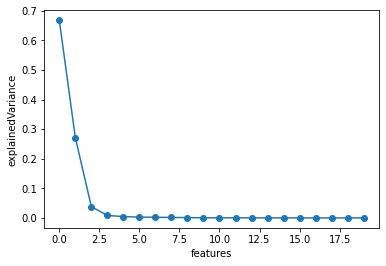

In [0]:
pcsdata.select("pca_test").show(5)
print(model.explainedVariance)
trs = 0
i = 0
while(trs < 0.98):
  trs += model.explainedVariance[i]
  i += 1
print("The ideal K value is:", i-1, ", include", trs*100, "% information.")

import matplotlib.pyplot as plt
plt.figure()
plt.plot(model.explainedVariance, marker = "o")
plt.xlabel("features")
plt.ylabel("explainedVariance")
plt.show()

As we can see in the figure, the ratio of the first 3 features add up to 95%, therefore we can use these 3 features to train the model

In [0]:
# Now let K be the proper value and get pca_features
if ("pca_features" in pcsdata.columns):
  pcsdata = pcsdata.drop("pca_features")
from pyspark.ml.feature import PCA
k = 3
pca = PCA(k = k, inputCol = "norm_test", outputCol="pca_features")
model = pca.fit(pcsdata)
pcsdata = model.transform(pcsdata)

Since our label is categorical, use stringindexer and onehotencoder to encode it

In [0]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
if "onehot_feature" in pcsdata.columns:
  pcsdata = pcsdata.drop("onehot_feature")
stringindexer = StringIndexer(inputCol="type", outputCol="onehot_feature")
# encoder = OneHotEncoder(dropLast=False, inputCols=["onehot_feature"], outputCols=["onehot_test"])
pipeline = Pipeline(stages=[stringindexer])
pipeline_fit = pipeline.fit(pcsdata)
pcsdata = pipeline_fit.transform(pcsdata)

In [0]:
pcsdata.select("type", "onehot_feature").show(10)

+------+--------------+
|  type|onehot_feature|
+------+--------------+
|   udp|           0.0|
|   tcp|           1.0|
|  junk|           4.0|
| combo|           3.0|
|   tcp|           1.0|
| combo|           3.0|
|benign|           2.0|
|benign|           2.0|
|benign|           2.0|
|  junk|           4.0|
+------+--------------+
only showing top 10 rows



In [0]:
data = pcsdata.select(["pca_features", "onehot_feature"])
data.show(5)
trainData, testData = data.randomSplit([0.8, 0.2], seed = randomSeed)

+--------------------+--------------+
|        pca_features|onehot_feature|
+--------------------+--------------+
|[0.77143669858187...|           0.0|
|[0.77143669858187...|           1.0|
|[-0.6179203287360...|           4.0|
|[-0.6133295971694...|           3.0|
|[0.77143669858187...|           1.0|
+--------------------+--------------+
only showing top 5 rows



In [0]:
btrainData = trainData
btestData = testData
for i in range(10):
  btrainData = btrainData.union(trainData)
  btestData = btestData.union(testData)
trainData = btrainData
testData = btestData

Now use SVM and logisticRegression to do the classification

In [0]:
# First Randomforest
from pyspark.ml.classification import RandomForestClassifier
mlp = RandomForestClassifier(labelCol="onehot_feature", featuresCol="pca_features")
mlpModel = mlp.fit(trainData)
predictions = mlpModel.transform(testData)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="onehot_feature")
evaluator.evaluate(predictions)

0.8752862697178369

## Since the structure of dataframe in Spark can not be used in models of sklearn, we have to redo the pre-processing of data for sklearn models.

In [0]:
import pandas as pd
skdata = pd.read_csv(dataPath+"concat_file.csv")

In [0]:
features = skdata.columns[:-1]
label = "type"

In [0]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
nskdata = ss.fit_transform(skdata[features])

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pcaModel = pca.fit(nskdata)

In [0]:
pcaModel.explained_variance_ratio_

array([6.66132535e-01, 2.40642184e-01, 3.75953264e-02, 1.95298054e-02,
       1.51945683e-02, 4.54870781e-03, 3.08354556e-03, 2.44957716e-03,
       2.06784826e-03, 1.51128238e-03, 9.96760313e-04, 8.87743215e-04,
       7.81302114e-04, 6.57394605e-04, 5.65601112e-04, 4.09304040e-04,
       4.04915932e-04, 3.34645017e-04, 2.48982719e-04, 2.48193826e-04])

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
rskdata = pca.fit_transform(nskdata)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
rlabel = le.fit_transform(skdata[label])

In [0]:
rdata = pd.DataFrame(data = rskdata)
rlabel = pd.DataFrame(data = rlabel)
rdata = pd.concat([rdata, rlabel], axis=1)

In [0]:
rdata.columns=["f1", "f2", "f3", "label"]
rdata.head(5)

,f1,f2,f3,label
0,-1.157335,-0.382128,0.053160,5
1,-1.157335,-0.382128,0.053160,4
2,2.668067,-0.639487,0.100772,2
3,2.446413,-0.495173,-0.034882,1
4,-1.157335,-0.382128,0.053160,4


In [0]:
from sklearn.model_selection import train_test_split
sktrainData, sktestData = train_test_split(rdata, random_state = randomSeed, train_size = 0.8)

In [0]:
bsktrainData = sktrainData
bsktestData = sktestData
for i in range(10):
  bsktrainData = pd.concat([bsktrainData, sktrainData])
  bsktestData = pd.concat([bsktestData, sktestData])
sktrainData = bsktrainData
sktestData = bsktestData

In [0]:
from sklearn.ensemble import RandomForestClassifier as rfc
mlp = rfc()
mlp.fit(sktrainData[fets], sktrainData["label"])
preditions = mlp.predict(sktestData[fets])

In [0]:
print("The accuracy on the training set is", mlp.score(sktestData[fets], sktestData["label"]))
print("The accuracy on the training set is", mlp.score(sktrainData[fets], sktrainData["label"]))

The accuracy on the training set is 0.732
The accuracy on the training set is 0.7482666666666666


In [0]:
# Now we define a time counter function
from timeit import Timer ## For timing 
from functools import partial ## For passing functions to be evaluated with arguments
def timeCnt(function = None, param = None):
  timeused = None
  if not function:
    print("Choose the target function.")
    return
#  try:
  t = Timer(partial(function, param))
  timeused = t.timeit(1)
#  except:
#    print("Error happened when running given function and param.")
#    return
  return timeused  


In [0]:
# put the classification block into a function
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
def rnd(ratio = 1):
  tnd = trainData.sample(ratio)
  ted = testData.sample(ratio) 
  mlp = RandomForestClassifier(labelCol="onehot_feature", featuresCol="pca_features")
  mlpModel = mlp.fit(tnd)
  predictions = mlpModel.transform(ted)

from sklearn.ensemble import RandomForestClassifier as rfc
def rndn(ratio = 1):
  tnd = sktrainData.sample(frac = ratio)
  ted = sktestData.sample(frac = ratio)
  mlp = rfc()
  mlp.fit(tnd[fets], tnd["label"])
  preditions = mlp.predict(ted[fets])

def lr(ratio = 1):
  tnd = trainData.sample(ratio)
  ted = testData.sample(ratio) 
  mlp = LogisticRegression(labelCol="onehot_feature", featuresCol="pca_features")
  mlpModel = mlp.fit(tnd)
  predictions = mlpModel.transform(ted)

from sklearn.linear_model import LogisticRegression as LR
def lrn(ratio = 1):
  tnd = sktrainData.sample(frac = ratio)
  ted = sktestData.sample(frac = ratio)
  mlp = LR(solver = "newton-cg")
  mlp.fit(tnd[fets], tnd["label"])
  preditions = mlp.predict(ted[fets])

In [0]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
rndtimes = []
for ratio in ratios:
  print("ratio", ratio, " begin.")
  rndtimes.append(timeCnt(rnd, ratio))
print("completed.")

In [0]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
rndntimes = []
for ratio in ratios:
  print("ratio", ratio, " begin.")
  rndntimes.append(timeCnt(rndn, ratio))
print("completed.")

ratio 0.1  begin.
ratio 0.3  begin.
ratio 0.5  begin.
ratio 0.7  begin.
ratio 0.9  begin.
completed.


In [0]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
lrtimes = []
for ratio in ratios:
  print("ratio", ratio, " begin.")
  lrtimes.append(timeCnt(lr, ratio))
print("completed.")

ratio 0.1  begin.
ratio 0.3  begin.
ratio 0.5  begin.
ratio 0.7  begin.
ratio 0.9  begin.
completed.


In [0]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
lrntimes = []
for ratio in ratios:
  print("ratio", ratio, " begin.")
  lrntimes.append(timeCnt(lrn, ratio))
print("completed.")

ratio 0.1  begin.
ratio 0.3  begin.
ratio 0.5  begin.
ratio 0.7  begin.
ratio 0.9  begin.
completed.


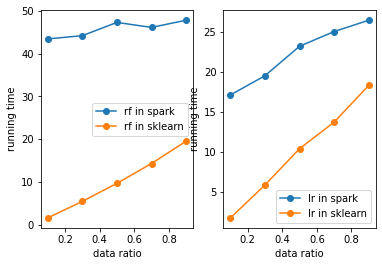

In [0]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(ratios, rndtimes, marker = "o")
plt.plot(ratios, rndntimes, marker = "o")
plt.xlabel("data ratio")
plt.ylabel("running time")
plt.legend(["rf in spark", "rf in sklearn"])

plt.subplot(122)
plt.plot(ratios, lrtimes, marker = "o")
plt.plot(ratios, lrntimes, marker = "o")
plt.xlabel("data ratio")
plt.ylabel("running time")
plt.legend(["lr in spark", "lr in sklearn"])
plt.show()

In [0]:
from sklearn import linear_model
import numpy as np
ratios = np.array(ratios)
clf1 = linear_model.LinearRegression()
clf2 = linear_model.LinearRegression()
clf3 = linear_model.LinearRegression()
clf4 = linear_model.LinearRegression()
clf1.fit(ratios.reshape(len(ratios),1),rndtimes)
print("RandomForst_Spark= ",clf1.coef_ ,"x + ", clf1.intercept_) # 得到相关系数
clf2.fit(ratios.reshape(len(ratios),1),rndntimes)
print("RandomForest_sklearn= ",clf2.coef_ ,"x + ", clf2.intercept_) # 得到相关系数

clf3.fit(ratios.reshape(len(ratios),1),lrtimes)
print("LogisticRegression_Spark= ",clf3.coef_ ,"x + ", clf3.intercept_) # 得到相关系数
clf4.fit(ratios.reshape(len(ratios),1),lrntimes)
print("LogisticRegression_sklearn= ",clf4.coef_ ,"x + ", clf4.intercept_) # 得到相关系数

RandomForst_Spark=  [5.34156928] x +  43.16039993249924
RandomForest_sklearn=  [22.41247149] x +  -1.1144534666520496
LogisticRegression_Spark=  [12.15219886] x +  16.211785143750784
LogisticRegression_sklearn=  [20.57461604] x +  -0.310082612501537


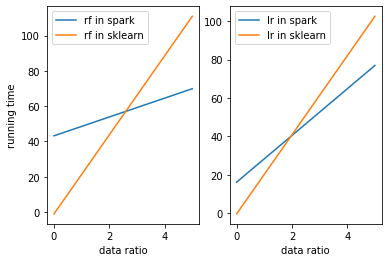

In [0]:
plt.figure("lines")
plt.subplot(121)
x = [[0], [5]]
plt.plot(x, clf1.coef_*x+clf1.intercept_)
plt.plot(x, clf2.coef_*x+clf2.intercept_)
plt.xlabel("data ratio")
plt.ylabel("running time")
plt.legend(["rf in spark", "rf in sklearn"])

plt.subplot(122)
x = [[0], [5]]
plt.plot(x, clf3.coef_*x+clf3.intercept_)
plt.plot(x, clf4.coef_*x+clf4.intercept_)
plt.xlabel("data ratio")
plt.legend(["lr in spark", "lr in sklearn"])


In [0]:
print("The cross point of Spark and sklearn for LogisticRegression is (", (clf3.intercept_ - clf4.intercept_) / (clf4.coef_ - clf3.coef_), ",", clf3.coef_*(clf3.intercept_ - clf4.intercept_) / (clf4.coef_ - clf3.coef_)+clf3.intercept_, ")")
print("The cross point of Spark and sklearn for RandomForest is (", (clf1.intercept_ - clf2.intercept_) / (clf2.coef_ - clf1.coef_), ",", clf1.coef_*(clf1.intercept_ - clf2.intercept_) / (clf2.coef_ - clf1.coef_)+clf1.intercept_, ")")

The cross point of Spark and sklearn for LogisticRegression is ( [1.96165393] , [40.05019378] )
The cross point of Spark and sklearn for RandomForest is ( [2.59358602] , [57.01421935] )


To verify the crossing point, we replicate our data set to make it larger.